In [96]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()

In [111]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Preprocess Data

## Fix Null Field Positions

In [112]:
print("Before")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())

# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)

print("After")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

Before
6424
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
After
0
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50


## Downsample, keep only entries where players is rusher

In [113]:
print("Before")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

# Only keep entries associated with rusher
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

print("After")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

Before
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)
After
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


## Calculate yards remaining (new feature)

In [114]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


Before
1 in Box Count: 1
2 in Box Count: 1
NaN in Box Count: 3
After
1 in Box Count: 0
2 in Box Count: 0
NaN in Box Count: 0


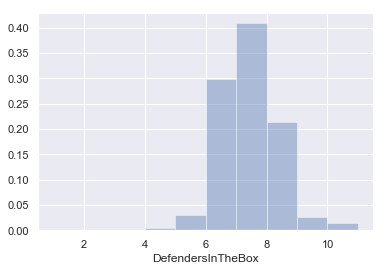

In [115]:
print("Before")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))
sns.distplot(df.DefendersInTheBox[df.DefendersInTheBox.isnull()==False], bins=11, kde=False, norm_hist=True)

# Fill nan with median (i.e. 7), and bump 1 or 2 (few samples) up to 3
df.DefendersInTheBox.fillna(7, inplace=True)
df.DefendersInTheBox.replace(to_replace=[1, 2], value=3, inplace=True)

print("After")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))

Before 

Position
FB         169
HB         616
Other       12
QB          77
RB       21628
TE          31
WR         638
dtype: int64

 After
Position
FB         169
HB         616
Other       12
QB          77
RB       21628
TE          31
WR         638
dtype: int64


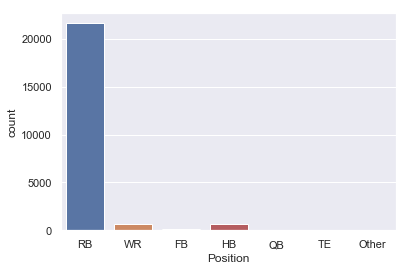

In [153]:
print("Before \n")
print(df.groupby(['Position']).size())
sns.countplot(x="Position", data=df)

# Change 'CB', 'DE', 'DT' (few samples) to 'Other'
df.Position.replace(to_replace=['CB', 'DE', 'DT'], value='Other', inplace=True)

print("\n After")
print(df.groupby(['Position']).size())

# Train and Dev Split

In [149]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 50)
(6952, 50)


# Perform MLE

## Calculate CDF with all data

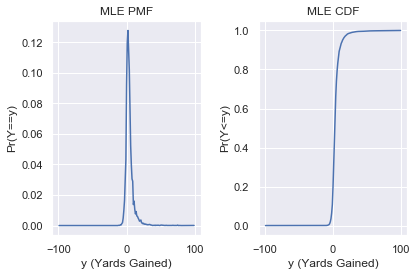

In [117]:
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
yard_cdf = np.cumsum(yard_probabilities)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), yard_probabilities)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y==y)', title='MLE PMF')
axes[1].plot(np.arange(-99,100), yard_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF')
plt.tight_layout()

## Squashing probabilities 

In [104]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

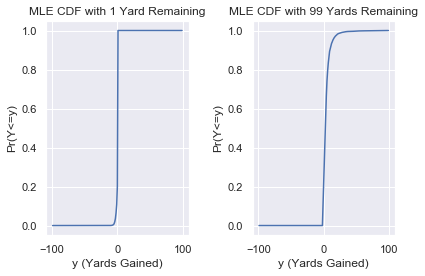

In [105]:
one_cdf = squash(yard_cdf, 1)
ninenine_cdf = squash(yard_cdf, 99)

fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(-99,100), one_cdf)
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 1 Yard Remaining')
axes[1].plot(np.arange(-99,100), ninenine_cdf)
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='MLE CDF with 99 Yards Remaining')
plt.tight_layout()

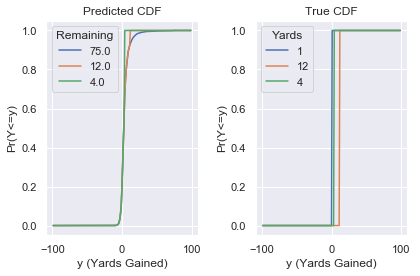

In [106]:
fig, axes = plt.subplots(1, 2)

for index, row in dev.head().iterrows():
    if index in [7177, 5312, 15852]:
        pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
        axes[0].plot(np.arange(-99,100), pred_cdf, label=row['YardsRemaining'])
        true_cdf = np.zeros(199)
        true_cdf[99+row['Yards']:] = 1
        axes[1].plot(np.arange(-99,100), true_cdf, label=row['Yards'])
        (pred_cdf-true_cdf)**2

    
axes[0].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='Predicted CDF')
axes[0].legend(title='Remaining')
axes[1].set(xlabel='y (Yards Gained)', ylabel='Pr(Y<=y)', title='True CDF')
axes[1].legend(title='Yards')
plt.tight_layout()

## Loss for model using all of the data

In [107]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044054093647522


## Investigating loss/cost

In [108]:
# dict to store [cumulative loss, # loss terms] for each yard_remaining
all_loss = {yard_remaining:[0, 0] for yard_remaining in range(1, 100)}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['YardsRemaining'])][0] += loss
    all_loss[int(row['YardsRemaining'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Yards Remaining)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Yards Remaining)


[(0.023656810243118855, 90),
 (0.019958763288461297, 60),
 (0.019861169052320174, 41),
 (0.019834543962703528, 64),
 (0.019449651165708407, 58),
 (0.018700459812563148, 88),
 (0.018551650968926615, 49),
 (0.017953948968883426, 84),
 (0.017740605128370147, 32),
 (0.017419316287308858, 66),
 (0.017243510481237546, 85),
 (0.01705987258763503, 45),
 (0.01699527863469708, 89),
 (0.01696655511089461, 35),
 (0.016914278624621405, 87),
 (0.01690794356831512, 42),
 (0.01681848095071732, 40),
 (0.016580795436014636, 65),
 (0.016459157001513895, 70),
 (0.01645547156748175, 47),
 (0.01643887897118454, 57),
 (0.01642111033514841, 50),
 (0.016162744302258888, 62),
 (0.016037374276890542, 80),
 (0.016004692403173516, 38),
 (0.01594305293816979, 75),
 (0.015853594613998715, 72),
 (0.015838794123628205, 74),
 (0.015584580332104223, 55),
 (0.015437757724239633, 79),
 (0.015374251592497256, 52),
 (0.015262430725008309, 48),
 (0.01515454541877643, 53),
 (0.015126129247456656, 68),
 (0.015075535970216287, 

In [118]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in range(3, 12)}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[int(row['DefendersInTheBox'])][0] += loss
    all_loss[int(row['DefendersInTheBox'])][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Defenders In The Box)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Defenders In The Box)


[(0.021231979668939697, 3),
 (0.019281554437827926, 4),
 (0.01634603109998031, 9),
 (0.01565466255081256, 5),
 (0.014557634316943896, 7),
 (0.01452820604207374, 6),
 (0.012452516507054423, 8),
 (0.003842475965125263, 10),
 (0.0035015824220201793, 11)]

In [150]:
# dict to store [cumulative loss, # loss terms] for each number of defenders in box
all_loss = {dib:[0, 0] for dib in df.Position.unique()}
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss[row['Position']][0] += loss
    all_loss[row['Position']][1] += 1
cost = {k:v[0]/v[1] for k, v in all_loss.items()}
print("(Cost, Position)")
sorted(((v,k) for k,v in cost.items()), reverse=True)

(Cost, Position)


[(0.02386267032119007, 'WR'),
 (0.022213490797284085, 'TE'),
 (0.015982754565858088, 'HB'),
 (0.014198417111545514, 'Other'),
 (0.013722944757777997, 'RB'),
 (0.011965115035621091, 'QB'),
 (0.010135827935035454, 'FB')]

# Perform MLE Segmented by Yardline

## Find model for each yard line

In [44]:
yard_counts = np.zeros((99,199), dtype = 'uint32')
yard_probabilities = np.zeros((99,199), dtype = 'float')

for yard_remaining in range(1,100):
    yards_current = train.Yards[train['YardsRemaining']==yard_remaining]
    
    for yard in range(-99, 100):
        yard_counts[yard_remaining-1,yard+99] = sum(yards_current==yard)
        
    yard_probabilities[yard_remaining-1,:] = yard_counts[yard_remaining-1,:] / np.sum(yard_counts[yard_remaining-1,:])
    
# CDF 
yard_cdf = np.zeros(yard_probabilities.shape)
for yard_remaining in range(1, 100):
    yard_cdf[yard_remaining-1] = np.cumsum(yard_probabilities[yard_remaining-1,:])

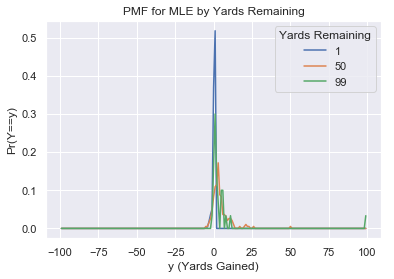

In [54]:
for yard_line in [1,50,99]:
    yard_line_index = yard_line -1
    plt.plot(np.arange(-99,100),yard_probabilities[yard_line_index,:], label = str(yard_line))
    
plt.title('PMF for MLE by Yards Remaining')
plt.ylabel('Pr(Y==y)')
plt.xlabel('y (Yards Gained)')
plt.legend(title='Yards Remaining');

In [51]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(yard_cdf[int(row['YardsRemaining'])-1,:], int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014088655099676866


# Boosted MLE by Yardline

## Using Gaussian kernel method to boost models for each yard line

In [52]:
#tune this as needed
sigma = 16
boosted_cdf = np.zeros(199)
weights = []
for true_remaining in range(1,100):
    for model_remaining in range (1,100):
        yard_line_cdf = yard_cdf[model_remaining-1,:]
        weight = np.exp(-((true_remaining - model_remaining)**2) / (2*(sigma**2)))
        weights.append(weight)
        boosted_cdf += weight*yard_line_cdf
        
#normalize the cdf
boosted_cdf /= np.sum(weights)  

## Compute loss for weighted model

In [53]:
all_loss = []
for index, row in dev.iterrows():
    pred_cdf = squash(boosted_cdf, int(row['YardsRemaining']))
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    loss = 1/199 * np.sum((pred_cdf-true_cdf)**2)
    all_loss.append(loss)
cost = np.average(all_loss)
print("Cost: {}".format(cost))

Cost: 0.014044888138695224
